## Deber Data Cleaning
### Christian Santamaria

### Carga de datos

In [1]:
import pandas as pd

file_path = 'nyc_taxi_hw.csv'
nyc_taxi_data = pd.read_csv(file_path)

nyc_taxi_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### Limpieza de datos

Se removeran columnas que no aportan información o no son claras: Unnamed: 0, y Key (Cierta modificacion en tiempo que ya está en pickup_datetime)

Asegurarnos que el tiempo esté en el formato correcto y eliminamos valores nulos.

In [2]:
nyc_taxi_data_cleaned = nyc_taxi_data.drop(columns=['Unnamed: 0', 'key'])
nyc_taxi_data_cleaned['pickup_datetime'] = pd.to_datetime(nyc_taxi_data_cleaned['pickup_datetime'], utc=True)
missing_values = nyc_taxi_data_cleaned.isnull().sum()

nyc_taxi_data_cleaned.head(), missing_values


(   fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
 0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
 1         16.9 2010-01-05 16:52:16+00:00        -74.016048        40.711303   
 2          5.7 2011-08-18 00:35:00+00:00        -73.982738        40.761270   
 3          7.7 2012-04-21 04:30:42+00:00        -73.987130        40.733143   
 4          5.3 2010-03-09 07:51:00+00:00        -73.968095        40.768008   
 
    dropoff_longitude  dropoff_latitude  passenger_count  
 0         -73.841610         40.712278                1  
 1         -73.979268         40.782004                1  
 2         -73.991242         40.750562                2  
 3         -73.991567         40.758092                1  
 4         -73.956655         40.783762                1  ,
 fare_amount          0
 pickup_datetime      0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count   

A continuación se modifican los datos para que puedan ser mejores y que tengan sentido.

Tarifas y número de pasajeros positivos.\
Latitud y longitud de origen y destino en los rangos correctos.\
Se despliega un poco de estadística descriptiva para entender mejor los datos.

In [3]:
nyc_taxi_data_cleaned = nyc_taxi_data_cleaned[(nyc_taxi_data_cleaned['fare_amount'] > 0) & 
                                              (nyc_taxi_data_cleaned['passenger_count'] > 0)]

# Rangos aceptables para las coordenadas de Nueva York
nyc_taxi_data_cleaned = nyc_taxi_data_cleaned[(nyc_taxi_data_cleaned['pickup_latitude'].between(40.5, 41.0)) &
                                              (nyc_taxi_data_cleaned['pickup_longitude'].between(-74.3, -73.7)) &
                                              (nyc_taxi_data_cleaned['dropoff_latitude'].between(40.5, 41.0)) &
                                              (nyc_taxi_data_cleaned['dropoff_longitude'].between(-74.3, -73.7))]

Q1 = nyc_taxi_data_cleaned['fare_amount'].quantile(0.25)
Q3 = nyc_taxi_data_cleaned['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

nyc_taxi_data_cleaned = nyc_taxi_data_cleaned[(nyc_taxi_data_cleaned['fare_amount'] >= lower_bound) & 
                                              (nyc_taxi_data_cleaned['fare_amount'] <= upper_bound)]

# Display results after filtering
nyc_taxi_data_cleaned.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,88972.000000,88972.000000,88972.000000,88972.000000,88972.000000,88972.000000
mean,8.936759,-73.979962,40.752162,-73.978165,40.752553,1.676100
std,4.150611,0.022001,0.023935,0.023280,0.026465,1.296003
min,0.010000,-74.295537,40.511087,-74.294613,40.505648,1.000000
25%,5.700000,-73.992523,40.737462,-73.991695,40.737302,1.000000
50%,8.000000,-73.982421,40.753492,-73.981170,40.754079,1.000000
75%,11.000000,-73.970157,40.767017,-73.967869,40.767985,2.000000
max,22.250000,-73.702795,40.988240,-73.701188,40.978090,6.000000


Como valor adicional, caculamos la distancia entre los puntos de origen y destino usando la fórmula de Haversine.

In [4]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radio de la tierra en KM
    return c * r

nyc_taxi_data_cleaned['trip_distance_km'] = nyc_taxi_data_cleaned.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], 
                                                                                            row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

nyc_taxi_data_cleaned[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']].head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.844311,40.721319,-73.841610,40.712278,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1.999157


Quitamos valores de distancia que sean inferiores a 10 metros ya que eso en la vida real no tiene sentido.

In [5]:
nyc_taxi_data_cleaned = nyc_taxi_data_cleaned[nyc_taxi_data_cleaned['trip_distance_km'] >= 0.010]

Dado que posteriormente se necesitan los datos de tiempo para la predicción, se extraen a nuevas columnas. 

In [6]:
nyc_taxi_data_cleaned['hour_of_day'] = nyc_taxi_data_cleaned['pickup_datetime'].dt.hour
nyc_taxi_data_cleaned['day_of_week'] = nyc_taxi_data_cleaned['pickup_datetime'].dt.dayofweek
nyc_taxi_data_cleaned['month_of_year'] = nyc_taxi_data_cleaned['pickup_datetime'].dt.month
nyc_taxi_data_cleaned = nyc_taxi_data_cleaned.drop(columns=['pickup_datetime'])

nyc_taxi_data_cleaned.head()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance_km,hour_of_day,day_of_week,month_of_year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,17,0,6
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,16,1,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,0,3,8
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,7,1,3


### Despliegue de datos

Veamos como varían los precios de los viajes dependiendo la hora del día.

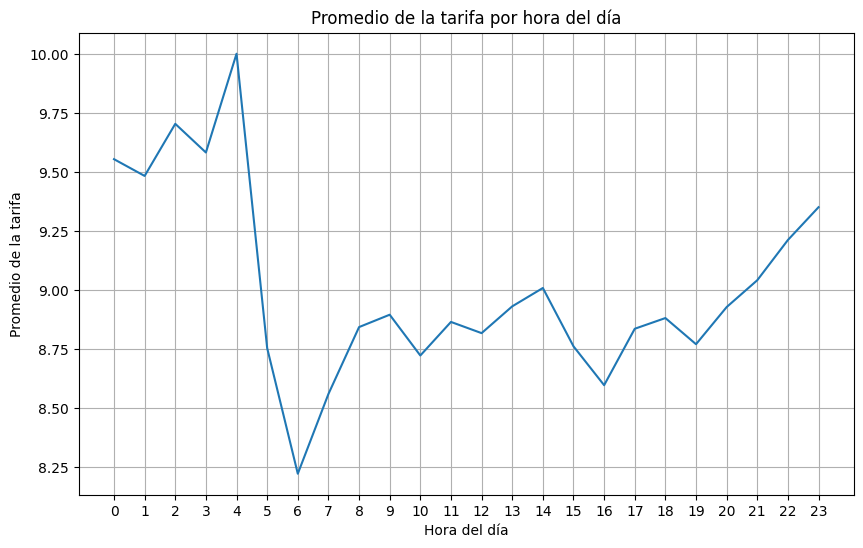

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Calcular el promedio de 'fare_amount' para cada 'hour_of_day'
average_fare_by_hour = nyc_taxi_data_cleaned.groupby('hour_of_day')['fare_amount'].mean()

plt.figure(figsize=(10, 6))
average_fare_by_hour.plot(kind='line')
plt.title('Promedio de la tarifa por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de la tarifa')

plt.xticks(range(0, 24)) 

plt.grid(True)
plt.show()


Tal parece que las tarifas más altas son en la madrugada y noche, mientras que las más bajas son en la tarde. Algo interesante de notar ya que en Quito las tarifas de taxi son más altas en la tarde debido al tráfico.

Veamos como varían los precios de los viajes dependiendo de la distancia.

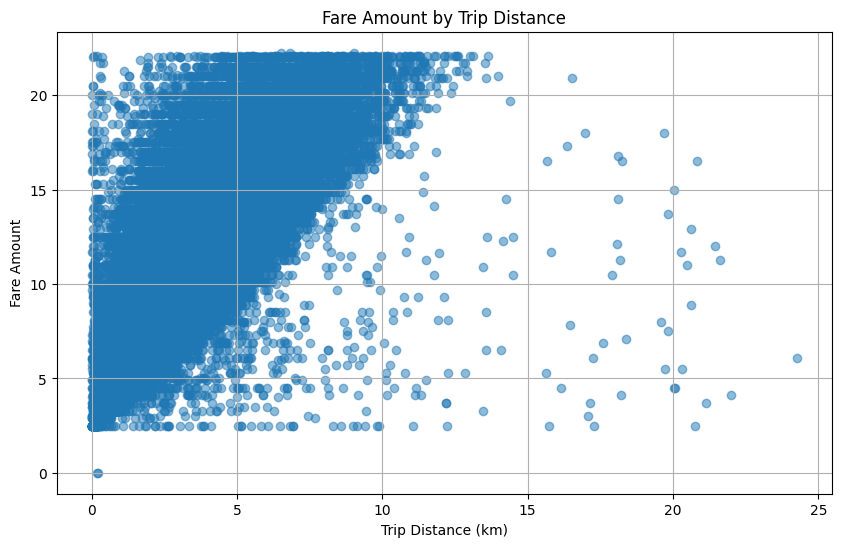

In [8]:
import matplotlib.pyplot as plt

# Asegurándose de que matplotlib muestre las gráficas correctamente en cuadernos de Jupyter
%matplotlib inline

# Crear un gráfico de dispersión para visualizar la tendencia de 'fare_amount' por kilómetros recorridos
plt.figure(figsize=(10, 6))
plt.scatter(nyc_taxi_data_cleaned['trip_distance_km'], nyc_taxi_data_cleaned['fare_amount'], alpha=0.5)
plt.title('Fare Amount by Trip Distance')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Fare Amount')
plt.grid(True)
plt.show()


Se nota un cúmulo de datos que tienen cierta tendencia lineal, es decir, que la tarifa crece con la distancia. Sin embargo, hay datos que no siguen esta tendencia, de hecho, hay casos raros en donde hay viajes cortos con tarifas altas y viajes largos con tarifas bajas. Sería algo de estudiar más a profundidad.

Finalmente, veamos veamos cuál es la hora más común para viajar.

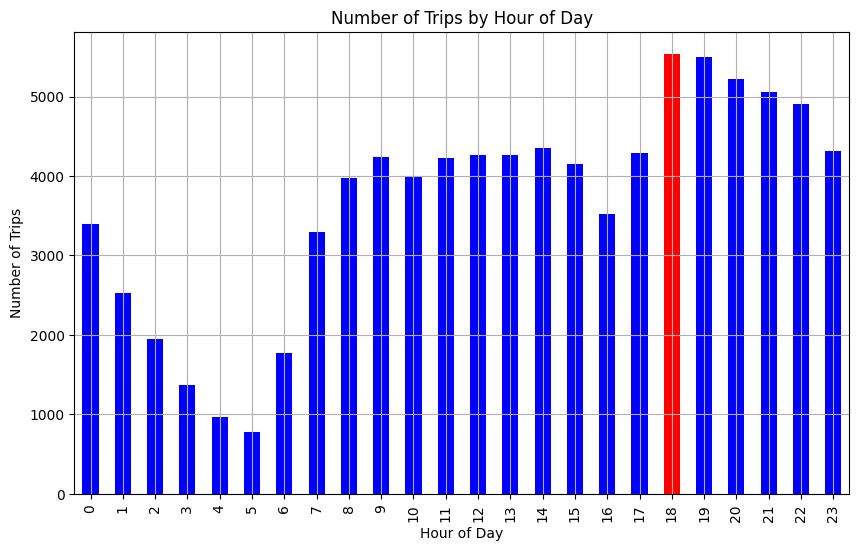

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurándose de que matplotlib muestre las gráficas correctamente en cuadernos de Jupyter
%matplotlib inline

# Contar la cantidad de viajes por cada 'hour_of_day'
trips_by_hour = nyc_taxi_data_cleaned['hour_of_day'].value_counts().sort_index()

# Crear un arreglo de colores, por defecto 'blue', excepto el máximo que será 'red'
colors = ['blue'] * len(trips_by_hour)
colors[trips_by_hour.argmax()] = 'red'  # 'red' para el máximo

# Crear un gráfico de barras para visualizar la cantidad de viajes por hora del día
plt.figure(figsize=(10, 6))
trips_by_hour.plot(kind='bar', color=colors)
plt.title('Number of Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()


Tal parece que a las 6 p.m. es la hora más común para viajar, seguido de las 7 p.m. y 8 p.m. Esto tiene sentido ya que a esas horas la gente sale de trabajar.

### Regresión lineal

Intentemos predecir la tarifa de un viaje en taxi en Nueva York usando regresión lineal.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Asumiendo que 'nyc_taxi_data_cleaned' ya está cargado y que todas las columnas son adecuadas para el modelo

# Seleccionar todas las columnas excepto 'fare_amount' como características
features = nyc_taxi_data_cleaned.drop('fare_amount', axis=1)

# La columna 'fare_amount' sigue siendo el objetivo
target = nyc_taxi_data_cleaned['fare_amount']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores de 'fare_amount' para el conjunto de prueba
predictions = model.predict(X_test)

# Calcular métricas para evaluar el modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2 Score: {r2}')


MSE: 5.854450407291116
MAE: 1.6949969250835544
R^2 Score: 0.6558087171821614


Métricas de rendimiento\
MSE (Mean Squared Error): Mide el promedio de los cuadrados de los errores. Cuanto menor sea el valor, mejor es el modelo.

MAE (Mean Absolute Error): Es el promedio de los valores absolutos de los errores. Proporciona una idea de cuán grandes son 
los errores en términos de cantidad.

R^2 (R-squared): Proporciona una indicación de la bondad del ajuste y por lo tanto una medida de cuán bien ocurren las observaciones futuras serán predichas por el modelo, con 1 siendo una predicción perfecta.

Los valores de las métricas no son lo suficientemente buenos, por lo que se podría intentar con otros modelos de forecasting. 